## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Unzipping dataset .zip file into 'dataset' folder

In [2]:
cd /content

/content


In [3]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins
!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Installing and importing required packages

In [ ]:
!pip install pyfeats

In [ ]:
!pip install mahotas

In [7]:
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pathlib
import cv2
import random
import shutil
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import mahotas
import pyfeats
import h5py
import warnings
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

## Getting image count per folder

In [8]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)
count = 1
total = 0
for folder in folders:
  print("{}.{} : {}".format(count, folder, len(os.listdir(dataset_path + folder))))
  count+=1
  total+= len(os.listdir(dataset_path + folder))
print("Total Images : {}".format(total))

1.Grape___Esca_(Black_Measles) : 1383
2.Corn___Northern_Leaf_Blight : 1000
3.Pepper,_bell___Bacterial_spot : 1000
4.Tomato___Target_Spot : 1404
5.Soybean___healthy : 5090
6.Corn___Cercospora_leaf_spot Gray_leaf_spot : 1000
7.Strawberry___healthy : 1000
8.Corn___healthy : 1162
9.Blueberry___healthy : 1502
10.Pepper,_bell___healthy : 1478
11.Apple___Cedar_apple_rust : 1000
12.Tomato___Leaf_Mold : 1000
13.Tomato___Early_blight : 1000
14.Apple___healthy : 1645
15.Peach___healthy : 1000
16.Potato___healthy : 1000
17.Cherry___Powdery_mildew : 1052
18.Cherry___healthy : 1000
19.Corn___Common_rust : 1192
20.Potato___Early_blight : 1000
21.Apple___Black_rot : 1000
22.Tomato___Tomato_mosaic_virus : 1000
23.Raspberry___healthy : 1000
24.Tomato___healthy : 1591
25.Orange___Haunglongbing_(Citrus_greening) : 5507
26.Tomato___Bacterial_spot : 2127
27.Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 1076
28.Grape___healthy : 1000
29.Grape___Black_rot : 1180
30.Tomato___Late_blight : 1909
31.Strawberry___L

## Getting names of all subfolders and storing them in variables for indexing and referencing purposes

In [9]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)

dataset_index = {}

for folder in folders:
  split = folder.split("__")

  if len(split) < 2:
    continue

  leaf_type = split[0].replace(",", "")
  
  if leaf_type in dataset_index.keys():
    dataset_index[leaf_type].append(folder)
  else:
    dataset_index[leaf_type] = [folder]

dataset_index

{'Grape': ['Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Grape___Black_rot'],
 'Corn': ['Corn___Northern_Leaf_Blight',
  'Corn___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn___healthy',
  'Corn___Common_rust'],
 'Pepper_bell': ['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy'],
 'Tomato': ['Tomato___Target_Spot',
  'Tomato___Leaf_Mold',
  'Tomato___Early_blight',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy',
  'Tomato___Bacterial_spot',
  'Tomato___Late_blight',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Septoria_leaf_spot'],
 'Soybean': ['Soybean___healthy'],
 'Strawberry': ['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
 'Blueberry': ['Blueberry___healthy'],
 'Apple': ['Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Apple_scab'],
 'Peach': ['Peach___healthy', 'Peach___Bacterial_spot'],
 'Potato': ['Potat

In [10]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)
type_of_leaves = {}

for folder in folders:
  leaf_type = folder.split("_")[0].replace(",", "")
  #print("Leaf Type: {}".format(leaf_type))
  variation = " ".join(folder.split("_")[1:]).strip()
  #print("Variation: {}".format(variation))
  if leaf_type in type_of_leaves.keys():
    type_of_leaves[leaf_type].append(variation)
  else:
    type_of_leaves[leaf_type] = [variation]

type_of_leaves

{'Grape': ['Esca (Black Measles)',
  'Leaf blight (Isariopsis Leaf Spot)',
  'healthy',
  'Black rot'],
 'Corn': ['Northern Leaf Blight',
  'Cercospora leaf spot Gray leaf spot',
  'healthy',
  'Common rust'],
 'Pepper': ['bell   Bacterial spot', 'bell   healthy'],
 'Tomato': ['Target Spot',
  'Leaf Mold',
  'Early blight',
  'Tomato mosaic virus',
  'healthy',
  'Bacterial spot',
  'Late blight',
  'Tomato Yellow Leaf Curl Virus',
  'Spider mites Two-spotted spider mite',
  'Septoria leaf spot'],
 'Soybean': ['healthy'],
 'Strawberry': ['healthy', 'Leaf scorch'],
 'Blueberry': ['healthy'],
 'Apple': ['Cedar apple rust', 'healthy', 'Black rot', 'Apple scab'],
 'Peach': ['healthy', 'Bacterial spot'],
 'Potato': ['healthy', 'Early blight', 'Late blight'],
 'Cherry': ['Powdery mildew', 'healthy'],
 'Raspberry': ['healthy'],
 'Orange': ['Haunglongbing (Citrus greening)'],
 'Background': ['without leaves'],
 'Squash': ['Powdery mildew']}

In [11]:
# eligible types of classification based on data
eligible_types = ['Pepper', 'Tomato', 'Corn', 'Grape', 'Apple', 'Strawberry', 'Peach', 'Cherry', 'Potato']

In [12]:
# view stats for an eligible type

eligible_type = "Cherry"
subset_of_folders = []
for folder in folders:
  if eligible_type in folder:
    subset_of_folders.append(folder)

count_healthy_leaves = 0
count_diseased_leaves = 0

for subset_folder in subset_of_folders:
  if "healthy" in subset_folder:
    count_healthy_leaves = len(os.listdir(dataset_path + subset_folder + "/"))
  else:
    count_diseased_leaves+= len(os.listdir(dataset_path + subset_folder + "/"))

print("For leaf type : {}".format(eligible_type))
print("No. of healthy leaves : {}".format(count_healthy_leaves))
print("No. of diseased leaves : {}".format(count_diseased_leaves))

For leaf type : Cherry
No. of healthy leaves : 1000
No. of diseased leaves : 1052


In [13]:
eligible_types_stats = {}

for eligible_type in eligible_types:

  subset_of_folders = []
  for folder in folders:
    if eligible_type in folder:
      subset_of_folders.append(folder)

  # getting subsets properly, checked manually for each eligible type
  #subset_of_folders

  count_healthy_leaves = 0
  count_diseased_leaves = 0

  for subset_folder in subset_of_folders:
    if "healthy" in subset_folder:
      count_healthy_leaves = len(os.listdir(dataset_path + subset_folder + "/"))
    else:
      count_diseased_leaves+= len(os.listdir(dataset_path + subset_folder + "/"))

  eligible_types_stats[eligible_type] = "healthy: {} | diseased: {}".format(count_healthy_leaves, count_diseased_leaves)

eligible_types_stats

{'Pepper': 'healthy: 1478 | diseased: 1000',
 'Tomato': 'healthy: 1591 | diseased: 17244',
 'Corn': 'healthy: 1162 | diseased: 3192',
 'Grape': 'healthy: 1000 | diseased: 3639',
 'Apple': 'healthy: 1645 | diseased: 3000',
 'Strawberry': 'healthy: 1000 | diseased: 1109',
 'Peach': 'healthy: 1000 | diseased: 2297',
 'Cherry': 'healthy: 1000 | diseased: 1052',
 'Potato': 'healthy: 1000 | diseased: 2000'}

## View random image of specific leaf type

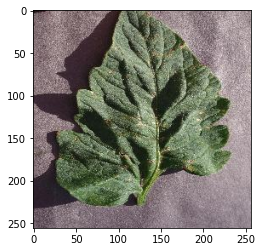

In [84]:
# Displays a random healthy image for the specific type of leaf
# Find at which index for a specific type does the healthy folder name exists in dataset_index dictionary
eligible_type = "Tomato"
healthy_folder_index = 6

path_to_folder = dataset_path + dataset_index[eligible_type][healthy_folder_index] + "/"
random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
image_name = "image ({}).JPG".format(random_image_number)
img = cv2.imread(path_to_folder + image_name)
# Converting BGR to RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Displays random images of all categories for a specific leaf type

In [85]:
# Displays random images of all categories for a specific leaf type
def show_all_categories_of_type(eligible_type):
  plt.figure(figsize=(50,50))
  number_of_categories = len(dataset_index[eligible_type])

  def read_img_and_show(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for i in range(number_of_categories):
    category = dataset_index[eligible_type][i]
    path_to_folder = dataset_path + category + "/"
    random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
    image_name = "image ({}).JPG".format(random_image_number)
    plt.subplot(1, number_of_categories, i+1)
    #plt.gca().set_title(" ".join(category.split("_")[1:]) + " : {}".format(image_name))
    plt.title(" ".join(category.split("_")[1:]) + " : {}".format(image_name), fontsize=25)
    plt.axis('off')
    plt.imshow(read_img_and_show(path_to_folder + image_name))
  
  plt.show()

In [86]:
show_all_categories_of_type("Apple")

Output hidden; open in https://colab.research.google.com to view.

## View preprocessing steps for pair of healthy and diseased images of specific leaf type

In [ ]:
# Displays processing of healthy & diseased images for a specific leaf type
def show_preprocessing_of_type(eligible_type):
  plt.figure(figsize=(25,15))
  # stages for preprocessing
  stages = ["Original", "HSV", "Green/Brown Segmentation"] 

  # folders for chosen leaf type
  number_of_categories = len(dataset_index[eligible_type])
  
  # we need to find which folder is healthy and pick a random diseased folder
  for i in range(number_of_categories):
    category = dataset_index[eligible_type][i]
    if "healthy" in category:
      healthy_folder_index = i

  diseased_folder_index = random.choice([i for i in range(number_of_categories) if i != healthy_folder_index])
  #print("Categories : {}".format(dataset_index[eligible_type]))
  #print("Healthy Folder Index : {}".format(healthy_folder_index))
  #print("Diseased Folder Index : {}".format(diseased_folder_index))

  def get_image(eligible_type, index):
    
    def read_img_and_show(path):
      img = cv2.imread(path)
      return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    category = dataset_index[eligible_type][index]
    path_to_folder = dataset_path + category + "/"
    random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
    image_name = "image ({}).JPG".format(random_image_number)
    path = path_to_folder + image_name
    return read_img_and_show(path)

  healthy_img = get_image(eligible_type, healthy_folder_index)
  diseased_img = get_image(eligible_type, diseased_folder_index)

  # Conversion to HSV image format from RGB
  def bgr_hsv(rgb_img):
      hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
      return hsv_img
  
  #Green/Brown Segmentation
  def img_segmentation(rgb_img,hsv_img):
    l_g = np.array([25,0,20])
    u_g = np.array([100,255,255])
    h_mask = cv2.inRange(hsv_img, l_g, u_g)
    h_result = cv2.bitwise_and(rgb_img,rgb_img, mask=h_mask)
    
    l_b = np.array([10,0,10])
    u_b = np.array([30,255,255])
    d_mask = cv2.inRange(hsv_img, l_b, u_b)
    d_result = cv2.bitwise_and(rgb_img, rgb_img, mask=d_mask)
    final_mask = h_mask + d_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

  #Original
  plt.subplot(2, 3, 1)
  plt.title(stages[0], fontsize=25)
  plt.axis('off')
  plt.imshow(healthy_img)

  plt.subplot(2, 3, 4)
  plt.title(stages[0], fontsize=25)
  plt.axis('off')
  plt.imshow(diseased_img)

  #HSV
  plt.subplot(2, 3, 2)
  plt.title(stages[1], fontsize=25)
  plt.axis('off')
  plt.imshow(bgr_hsv(healthy_img))

  plt.subplot(2, 3, 5)
  plt.title(stages[1], fontsize=25)
  plt.axis('off')
  plt.imshow(bgr_hsv(diseased_img))

  #Green/Brown Segmentation
  healthy_img_seg = img_segmentation(healthy_img, bgr_hsv(healthy_img))
  plt.subplot(2, 3, 3)
  plt.title(stages[2], fontsize=25)
  plt.axis('off')
  plt.imshow(healthy_img_seg)

  diseased_img_seg = img_segmentation(diseased_img, bgr_hsv(diseased_img))
  plt.subplot(2, 3, 6)
  plt.title(stages[2], fontsize=25)
  plt.axis('off')
  plt.imshow(diseased_img_seg)
  plt.show()

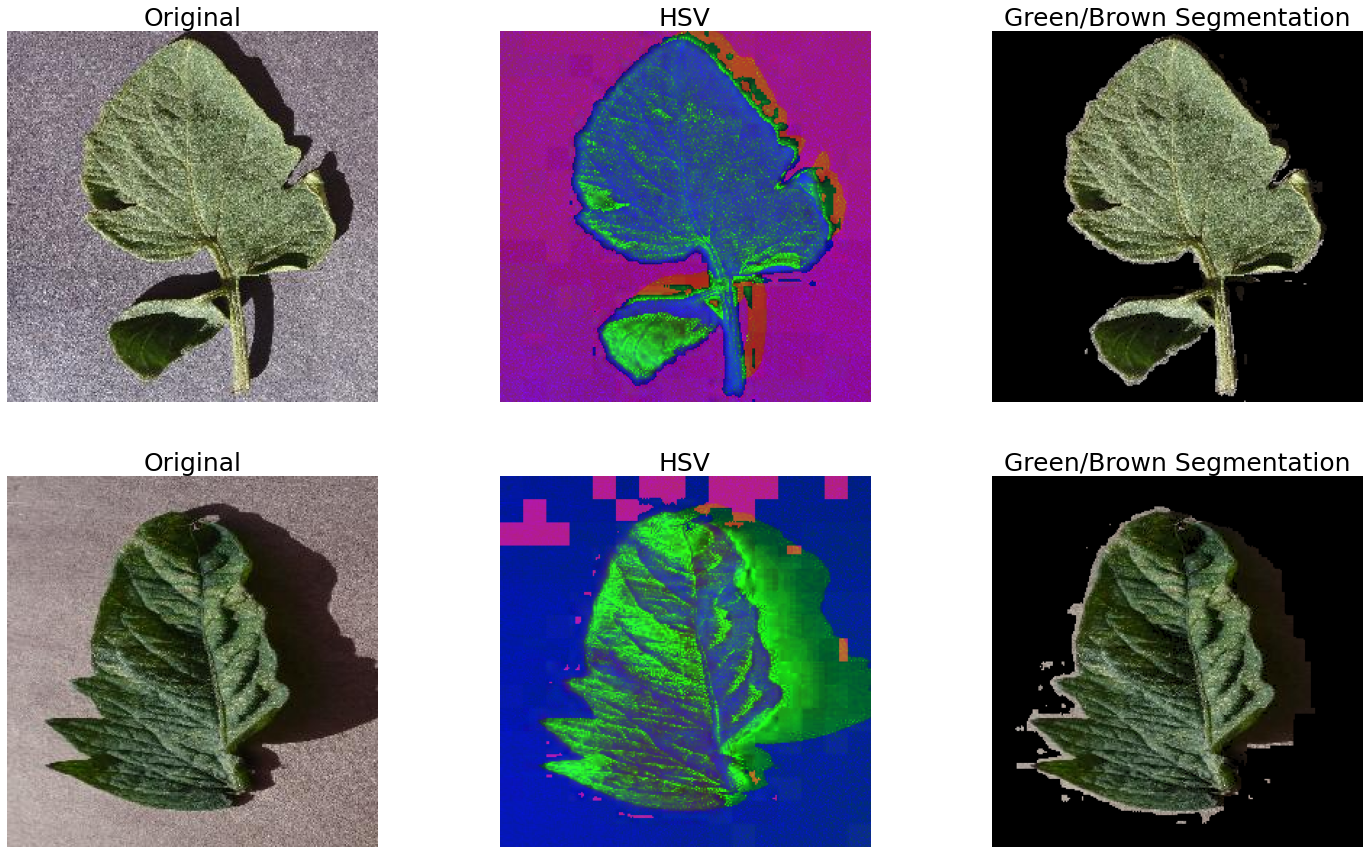

In [ ]:
show_preprocessing_of_type("Tomato")

## View feature extraction for pair of healthy and diseased images of specific leaf type

In [ ]:
# Displays processing of healthy & diseased images for a specific leaf type
def show_feature_extraction_of_type(eligible_type):
  plt.figure(figsize=(25,15))
  # stages for preprocessing
  stages = ["Hu Moments", "Haralick Texture", "Color Histogram"] 
  bins = 8
  # folders for chosen leaf type
  number_of_categories = len(dataset_index[eligible_type])
  
  # we need to find which folder is healthy and pick a random diseased folder
  for i in range(number_of_categories):
    category = dataset_index[eligible_type][i]
    if "healthy" in category:
      healthy_folder_index = i

  diseased_folder_index = random.choice([i for i in range(number_of_categories) if i != healthy_folder_index])
  #print("Categories : {}".format(dataset_index[eligible_type]))
  #print("Healthy Folder Index : {}".format(healthy_folder_index))
  #print("Diseased Folder Index : {}".format(diseased_folder_index))

  def get_image(eligible_type, index):
    
    def read_img_and_show(path):
      img = cv2.imread(path)
      return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    category = dataset_index[eligible_type][index]
    path_to_folder = dataset_path + category + "/"
    random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
    image_name = "image ({}).JPG".format(random_image_number)
    path = path_to_folder + image_name
    return read_img_and_show(path)

  healthy_img = get_image(eligible_type, healthy_folder_index)
  diseased_img = get_image(eligible_type, diseased_folder_index)

  # Conversion to HSV image format from RGB
  def bgr_hsv(rgb_img):
      hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
      return hsv_img
  
  #Green/Brown Segmentation
  def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

  # feature-descriptor-1: Hu Moments
  def fd_hu_moments(image):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      feature = cv2.HuMoments(cv2.moments(image)).flatten()
      return feature

  # feature-descriptor-2: Haralick Texture
  def fd_haralick(image):
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      haralick = mahotas.features.haralick(gray).mean(axis=0)
      return haralick

  # feature-descriptor-3: Color Histogram
  def fd_histogram(image, mask=None):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
      hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      return hist.flatten()

  healthy_img_seg = img_segmentation(healthy_img, bgr_hsv(healthy_img))
  healthy_hu_moments = fd_hu_moments(healthy_img_seg)
  healthy_haralick_texture = fd_haralick(healthy_img_seg)
  healthy_color_histogram = fd_histogram(healthy_img_seg)

  diseased_img_seg = img_segmentation(diseased_img, bgr_hsv(diseased_img))
  diseased_hu_moments = fd_hu_moments(diseased_img_seg)
  diseased_haralick_texture = fd_haralick(diseased_img_seg)
  diseased_color_histogram = fd_histogram(diseased_img_seg)


  # print(len(healthy_hu_moments))
  # print(len(healthy_haralick_texture))
  # print(len(healthy_color_histogram))

  x1points = [x for x in range(len(healthy_hu_moments))]
  y1points = healthy_hu_moments

  x2points = [x for x in range(len(healthy_haralick_texture))]
  y2points = healthy_haralick_texture


  plt.figure(figsize=(5,5))
  plt.plot(x2points, y2points, 'o') 
  plt.show()

<Figure size 1800x1080 with 0 Axes>

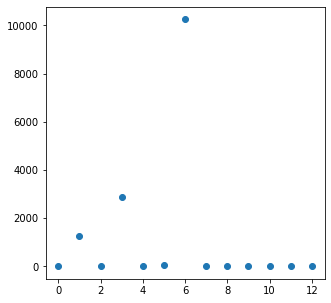

In [ ]:
show_feature_extraction_of_type("Tomato")

## Additional feature extraction

In [ ]:
!pip install pyfeats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyfeats: filename=pyfeats-1.0.0-py3-none-any.whl size=49741 sha256=0b7031b534feb4e1db0be33f77040b00a3c6a46a7eb6f4ef3f8acafec465927b
  Stored in directory: /root/.cache/pip/wheels/fc/18/b5/cb0a301584251bf4d4e8678a2a6996897df5129c47708c14de
Successfully built pyfeats


In [ ]:
import pyfeats

In [ ]:
def get_grayscale_image_and_roi_mask(eligible_type):
  # folder for chosen leaf type
  number_of_categories = len(dataset_index[eligible_type])
  folder_index = random.choice([i for i in range(number_of_categories)])

  # read image
  category = dataset_index[eligible_type][folder_index]
  path_to_folder = dataset_path + category + "/"
  random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
  image_name = "image ({}).JPG".format(random_image_number)
  path = path_to_folder + image_name
  img = cv2.imread(path)
  
  #convert image to rgb & hsv
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

  #get grayscale image
  grayscale = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_BGR2RGB) 

  #create green/brown mask
  lower_green = np.array([25,0,20])
  upper_green = np.array([100,255,255])
  healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
  lower_brown = np.array([10,0,10])
  upper_brown = np.array([30,255,255])
  disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
  disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
  final_mask = healthy_mask + disease_mask

  return grayscale, final_mask

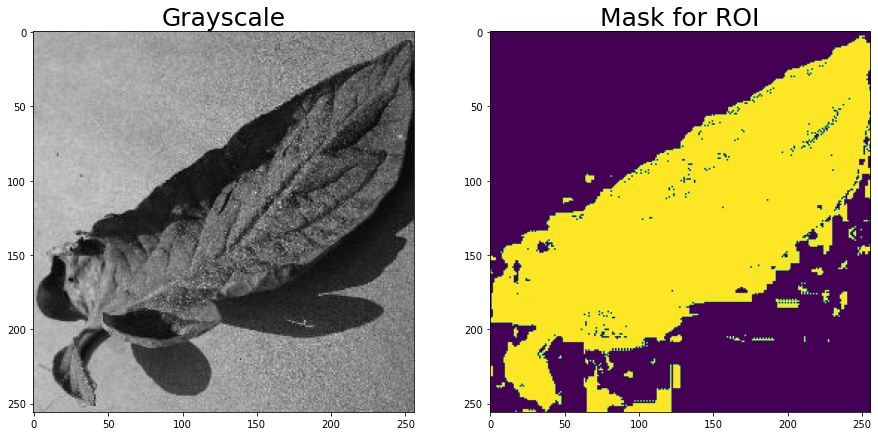

In [ ]:
grayscale, mask = get_grayscale_image_and_roi_mask("Tomato")

plt.figure(figsize=(15,15))

plt.subplot(1, 2, 1)
plt.title("Grayscale", fontsize=25)
#plt.axis('off')
plt.imshow(grayscale)

plt.subplot(1, 2, 2)
plt.title("Mask for ROI", fontsize=25)
#plt.axis('off')
plt.imshow(mask)

plt.show()

In [ ]:
#First Order Statistics/Statistical Features (FOS/SF)
features, labels = pyfeats.fos(grayscale[:,:,0], mask)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['FOS_Mean', 'FOS_Variance', 'FOS_Median', 'FOS_Mode', 'FOS_Skewness', 'FOS_Kurtosis', 'FOS_Energy', 'FOS_Entropy', 'FOS_MinimalGrayLevel', 'FOS_MaximalGrayLevel', 'FOS_CoefficientOfVariation', 'FOS_10Percentile', 'FOS_25Percentile', 'FOS_75Percentile', 'FOS_90Percentile', 'FOS_HistogramWidth']
Features: [8.25804902e+01 2.09778453e+03 8.10000000e+01 2.60000000e+01
 3.26248088e-01 2.19770640e+00 7.04159585e-03 5.09636917e+00
 7.00000000e+00 2.20000000e+02 1.08984579e-01 2.50000000e+01
 3.90000000e+01 1.14000000e+02 1.47000000e+02 1.22000000e+02]


In [ ]:
# Gray Level Co-occurence Matrix (GLCM/SGLDM)
features_mean, features_range, labels_mean, labels_range = pyfeats.glcm_features(grayscale[:,:,0], ignore_zeros=True)
print("Labels Mean : {}".format(labels_mean))
print("Features Mean : {}".format(features_mean))
print("Labels Range : {}".format(labels_range))
print("Features Range : {}".format(features_range))

Labels Mean : ['GLCM_ASM_Mean', 'GLCM_Contrast_Mean', 'GLCM_Correlation_Mean', 'GLCM_SumOfSquaresVariance_Mean', 'GLCM_InverseDifferenceMoment_Mean', 'GLCM_SumAverage_Mean', 'GLCM_SumVariance_Mean', 'GLCM_SumEntropy_Mean', 'GLCM_Entropy_Mean', 'GLCM_DifferenceVariance_Mean', 'GLCM_DifferenceEntropy_Mean', 'GLCM_Information1_Mean', 'GLCM_Information2_Mean', 'GLCM_MaximalCorrelationCoefficient_Mean']
Features Mean : [ 1.77939368e-04  5.22053405e+02  9.14899731e-01  3.06727400e+03
  1.17120193e-01  2.28441562e+02  1.17470426e+04  8.43324372e+00
  1.33310491e+01  1.45398251e-04  5.34404528e+00 -2.13918776e-01
  9.78999877e-01  6.54620928e+00]
Labels Range : ['GLCM_ASM_Range', 'GLCM_Contrast_Range', 'GLCM_Correlation_Range', 'GLCM_SumOfSquaresVariance_Range', 'GLCM_InverseDifferenceMoment_Range', 'GLCM_SumAverage_Range', 'GLCM_SumVariance_Range', 'GLCM_SumEntropy_Range', 'GLCM_Entropy_Range', 'GLCM_DifferenceVariance_Range', 'GLCM_DifferenceEntropy_Range', 'GLCM_Information1_Range', 'GLCM_I

In [ ]:
# Gray Level Difference Statistics (GLDS)
features, labels = pyfeats.glds_features(grayscale[:,:,0], mask, Dx=[0,1,1,1], Dy=[1,1,0,-1])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GLDS_Homogeneity', 'GLDS_Contrast', 'GLDS_ASM', 'GLDS_Entopy', 'GLDS_Mean']
Features: [ 2.92660000e+04  0.00000000e+00  8.56498756e+08 -3.00976862e+05
  0.00000000e+00]


In [ ]:
#Neighborhood Gray Tone Difference Matrix (NGTDM)
features, labels = pyfeats.ngtdm_features(grayscale[:,:,0], mask, d=1)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['NGTDM_Coarseness', 'NGTDM_Contrast', 'NGTDM_Busyness', 'NGTDM_Complexity', 'NGTDM_Strngth']
Features: [nan nan nan nan  0.]


In [ ]:
#Statistical Feature Matrix (SFM)
features, labels = pyfeats.sfm_features(grayscale[:,:,0], mask, Lr=4, Lc=4)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['SFM_Coarseness', 'SFM_Contrast', 'SFM_Periodicity', 'SFM_Roughness']
Features: [3.83625407e+00 1.00048877e+04 3.17020334e-01 2.68063189e+00]


In [ ]:
#Law's Texture Energy Measures (LTE/TEM)
features, labels = pyfeats.lte_measures(grayscale[:,:,0], mask, l=7)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['LTE_LL_7', 'LTE_EE_7', 'LTE_SS_7', 'LTE_LE_7', 'LTE_ES_7', 'LTE_LS_7']
Features: [nan nan nan nan nan nan]


In [ ]:
#Fractal Dimension Texture Analysis (FDTA)
h, labels = pyfeats.fdta(grayscale[:,:,0], mask, s=3)
print("Labels: {}".format(labels))
print("Features: {}".format(h))

Labels: ['FDTA_HurstCoeff_1', 'FDTA_HurstCoeff_2', 'FDTA_HurstCoeff_3', 'FDTA_HurstCoeff_4']
Features: [       nan 0.30070437 0.2738442  0.29791064]


In [ ]:
# Gray Level Run Length Matrix (GLRLM)
features, labels = pyfeats.glrlm_features(grayscale[:,:,0], mask, Ng=256)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GLRLM_ShortRunEmphasis', 'GLRLM_LongRunEmphasis', 'GLRLM_GrayLevelNo-Uniformity', 'GLRLM_RunLengthNonUniformity', 'GLRLM_RunPercentage', 'GLRLM_LowGrayLevelRunEmphasis', 'GLRLM_HighGrayLevelRunEmphasis', 'GLRLM_Short owGrayLevelEmphasis', 'GLRLM_ShortRunHighGrayLevelEmphasis', 'GLRLM_LongRunLowGrayLevelEmphasis', 'GLRLM_LongRunHighGrayLevelEmphasis']
Features: [9.69062592e-01 1.15081654e+00 3.86731420e+02 5.77959976e+04
 9.60140931e-01 1.11684433e+12 1.59724208e+04 1.11684433e+12
 1.54945486e+04 1.00000000e+00 1.81067624e+04]


In [ ]:
# Fourier Power Spectrum (FPS)
features, labels = pyfeats.fps(grayscale[:,:,0], mask)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

In [ ]:
# Gray Level Size Zone Matrix (GLSZM)
features, labels = pyfeats.glszm_features(grayscale[:,:,0], mask)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GLSZM_SmallZoneEmphasis', 'GLSZM_LargeZoneEmphasis', 'GLSZM_GrayLevelNonuniformity', 'GLSZM_ZoneSizeNonuniformity', 'GLSZM_ZonePercentage', 'GLSZM_LowGrayLeveLZoneEmphasis', 'GLSZM_HighGrayLevelZoneEmphasis', 'GLSZM_SmallZoneLowGrayLevelEmphasis', 'GLSZM_SmallZoneHighGrayLevelEmphasis', 'GLSZM_LargeZoneLowGrayLevelEmphassis', 'GLSZM_LargeZoneHighGrayLevelEmphasis', 'GLSZM_GrayLevelVariance', 'GLSZM_ZoneSizeVariance', 'GLSZM_ZoneSizeEntropy']
Features: [ 9.90441499e-01  3.98561234e+07  6.68726048e-03  9.80815472e-01
  4.48768472e+01  5.34638678e-04  9.45674821e+03  4.74368462e-04
  9.25353689e+03  2.57313737e+05  8.70756848e+11  2.85120684e-06
  8.70896898e-05 -7.43461968e+00]


In [ ]:
# Higher Order Spectra (HOS)
features, labels = pyfeats.hos_features(grayscale[:,:,0], th=[135,140])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['HOS_135_degrees', 'HOS_140_degrees']
Features: [6.83598677 6.9397638 ]


In [ ]:
#  Local Binary Pattern (LPB)
features, labels = pyfeats.lbp_features(grayscale[:,:,0], mask, P=[8,16,24], R=[1,2,3])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['LBP_R_1_P_8_energy', 'LBP_R_1_P_8_entropy', 'LBP_R_2_P_16_energy', 'LBP_R_2_P_16_entropy', 'LBP_R_3_P_24_energy', 'LBP_R_3_P_24_entropy']
Features: [ 6.98734134 -1.86989136 15.29390959 -2.6845144  23.4707473  -3.12780377]


In [ ]:
# Gray-scale Morphological Analysis
pdf, cdf = pyfeats.grayscale_morphology_features(grayscale[:,:,0], N=30)
print("pdf: {}".format(pdf))
print("cdf: {}".format(cdf))

pdf: [0.0583833  0.04091182 0.03093514 0.02492654 0.02269469 0.01955484
 0.01697066 0.01569497 0.01468424 0.01299485 0.01293602 0.01281928
 0.01117244 0.01047643 0.01247361 0.00801619 0.01130759 0.00726201
 0.00670768 0.00878504 0.00872314 0.0096833  0.00607584 0.01125876
 0.0074205  0.00724146 0.00772255 0.00555474 0.00350927 0.00932789]
cdf: [0.0583833  0.09929512 0.13023026 0.1551568  0.1778515  0.19740634
 0.214377   0.23007197 0.24475621 0.25775106 0.27068708 0.28350636
 0.2946788  0.30515523 0.31762884 0.32564503 0.33695262 0.34421463
 0.35092231 0.35970735 0.36843048 0.37811378 0.38418963 0.39544839
 0.40286889 0.41011035 0.4178329  0.42338763 0.4268969  0.43622479]


In [ ]:
# Multilevel Binary Morphological Analysis
pdf_L, pdf_M, pdf_H, cdf_L, cdf_M, cdf_H = pyfeats.multilevel_binary_morphology_features(grayscale[:,:,0], mask, N=30, thresholds=[25, 50])
print("pdf_L: {}".format(pdf_L))
print("pdf_M: {}".format(pdf_M))
print("pdf_H: {}".format(pdf_H))
print("cdf_L: {}".format(cdf_L))
print("cdf_M: {}".format(cdf_M))
print("cdf_H: {}".format(cdf_H))

pdf_L: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
pdf_M: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
pdf_H: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
cdf_L: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
cdf_M: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
cdf_H: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]


In [ ]:
# Gabor Transform (GT)
features, labels = pyfeats.gt_features(grayscale[:,:,0], mask, deg=4, freq=[0.05, 0.4])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['GT_th_0.0_freq_0.05_mean', 'GT_th_0.0_freq_0.05_std', 'GT_th_0.0_freq_0.4_mean', 'GT_th_0.0_freq_0.4_std', 'GT_th_1.0_freq_0.05_mean', 'GT_th_1.0_freq_0.05_std', 'GT_th_1.0_freq_0.4_mean', 'GT_th_1.0_freq_0.4_std', 'GT_th_2.0_freq_0.05_mean', 'GT_th_2.0_freq_0.05_std', 'GT_th_2.0_freq_0.4_mean', 'GT_th_2.0_freq_0.4_std', 'GT_th_3.0_freq_0.05_mean', 'GT_th_3.0_freq_0.05_std', 'GT_th_3.0_freq_0.4_mean', 'GT_th_3.0_freq_0.4_std']
Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# features, labels = zernikes_moments(f, radius=9)
features, labels = pyfeats.zernikes_moments(grayscale[:,:,0], radius=9)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['Zernikes_Moments_radius_9_0', 'Zernikes_Moments_radius_9_1', 'Zernikes_Moments_radius_9_2', 'Zernikes_Moments_radius_9_3', 'Zernikes_Moments_radius_9_4', 'Zernikes_Moments_radius_9_5', 'Zernikes_Moments_radius_9_6', 'Zernikes_Moments_radius_9_7', 'Zernikes_Moments_radius_9_8', 'Zernikes_Moments_radius_9_9', 'Zernikes_Moments_radius_9_10', 'Zernikes_Moments_radius_9_11', 'Zernikes_Moments_radius_9_12', 'Zernikes_Moments_radius_9_13', 'Zernikes_Moments_radius_9_14', 'Zernikes_Moments_radius_9_15', 'Zernikes_Moments_radius_9_16', 'Zernikes_Moments_radius_9_17', 'Zernikes_Moments_radius_9_18', 'Zernikes_Moments_radius_9_19', 'Zernikes_Moments_radius_9_20', 'Zernikes_Moments_radius_9_21', 'Zernikes_Moments_radius_9_22', 'Zernikes_Moments_radius_9_23', 'Zernikes_Moments_radius_9_24']
Features: [0.31830989 0.14164094 0.06468454 0.04657032 0.02485348 0.01545028
 0.00741803 0.02312478 0.01430554 0.02215687 0.00201932 0.07548473
 0.00663338 0.04801769 0.04195491 0.02959147 0.07039103 0

In [ ]:
# Threshold Adjacency Matrix (TAS)
features, labels = pyfeats.tas_features(grayscale[:,:,0])
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['TAS0', 'TAS1', 'TAS2', 'TAS3', 'TAS4', 'TAS5', 'TAS6', 'TAS7', 'TAS8', 'TAS9', 'TAS10', 'TAS11', 'TAS12', 'TAS13', 'TAS14', 'TAS15', 'TAS16', 'TAS17', 'TAS18', 'TAS19', 'TAS20', 'TAS21', 'TAS22', 'TAS23', 'TAS24', 'TAS25', 'TAS26', 'TAS27', 'TAS28', 'TAS29', 'TAS30', 'TAS31', 'TAS32', 'TAS33', 'TAS34', 'TAS35', 'TAS36', 'TAS37', 'TAS38', 'TAS39', 'TAS40', 'TAS41', 'TAS42', 'TAS43', 'TAS44', 'TAS45', 'TAS46', 'TAS47', 'TAS48', 'TAS49', 'TAS50', 'TAS51', 'TAS52', 'TAS53']
Features: [0.63156989 0.11704115 0.07352869 0.05042037 0.03719455 0.03087664
 0.02485373 0.02286248 0.01165249 0.68067944 0.11192558 0.06220377
 0.04601254 0.03273573 0.02422797 0.01916453 0.01468986 0.00836056
 0.74360264 0.10084841 0.05234513 0.03697775 0.0256809  0.01733403
 0.01237165 0.00715772 0.00368177 0.37279749 0.19003942 0.13693781
 0.10101376 0.06951484 0.0494006  0.03721136 0.02570601 0.01737871
 0.68707828 0.0850255  0.06209016 0.05372699 0.03719074 0.02695853
 0.02100295 0.01488897 0.01203789 0.

In [ ]:
#  Histogram of Oriented Gradients (HOG)
fd, labels = pyfeats.hog_features(grayscale[:,:,0], ppc=8, cpb=3)
print("Labels: {}".format(labels))
print("Features: {}".format(features))

Labels: ['HOS_ppc_8_cpb3_0', 'HOS_ppc_8_cpb3_1', 'HOS_ppc_8_cpb3_2', 'HOS_ppc_8_cpb3_3', 'HOS_ppc_8_cpb3_4', 'HOS_ppc_8_cpb3_5', 'HOS_ppc_8_cpb3_6', 'HOS_ppc_8_cpb3_7', 'HOS_ppc_8_cpb3_8', 'HOS_ppc_8_cpb3_9', 'HOS_ppc_8_cpb3_10', 'HOS_ppc_8_cpb3_11', 'HOS_ppc_8_cpb3_12', 'HOS_ppc_8_cpb3_13', 'HOS_ppc_8_cpb3_14', 'HOS_ppc_8_cpb3_15', 'HOS_ppc_8_cpb3_16', 'HOS_ppc_8_cpb3_17', 'HOS_ppc_8_cpb3_18', 'HOS_ppc_8_cpb3_19', 'HOS_ppc_8_cpb3_20', 'HOS_ppc_8_cpb3_21', 'HOS_ppc_8_cpb3_22', 'HOS_ppc_8_cpb3_23', 'HOS_ppc_8_cpb3_24', 'HOS_ppc_8_cpb3_25', 'HOS_ppc_8_cpb3_26', 'HOS_ppc_8_cpb3_27', 'HOS_ppc_8_cpb3_28', 'HOS_ppc_8_cpb3_29', 'HOS_ppc_8_cpb3_30', 'HOS_ppc_8_cpb3_31', 'HOS_ppc_8_cpb3_32', 'HOS_ppc_8_cpb3_33', 'HOS_ppc_8_cpb3_34', 'HOS_ppc_8_cpb3_35', 'HOS_ppc_8_cpb3_36', 'HOS_ppc_8_cpb3_37', 'HOS_ppc_8_cpb3_38', 'HOS_ppc_8_cpb3_39', 'HOS_ppc_8_cpb3_40', 'HOS_ppc_8_cpb3_41', 'HOS_ppc_8_cpb3_42', 'HOS_ppc_8_cpb3_43', 'HOS_ppc_8_cpb3_44', 'HOS_ppc_8_cpb3_45', 'HOS_ppc_8_cpb3_46', 'HOS_ppc_8_cpb

## Creating curated dataset for classification for a specific leaf type

In [31]:
# creating folder structure for specific eligible type of leaf
eligible_type = "Apple"

base_path = "/content/"
curated_dataset = "curated_dataset/" 
classes = ["healthy", "diseased"]

for c in classes:
  path = base_path + curated_dataset + eligible_type + "/" + c + "/"
  p = pathlib.Path(path)
  p.mkdir(parents=True, exist_ok=True)

In [32]:
# copying images from source subfolders to destination class folders ("healthy" & "diseased") for a specific eligible type of leaf

eligible_type = "Apple"

# source
source_dataset = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
source_folders = dataset_index[eligible_type]

# destination
destination_dataset = "/content/curated_dataset/{}/".format(eligible_type)
classes = ["healthy", "diseased"]
healthy_count = 0
diseased_count = 0

for source_folder in tqdm(source_folders):
  source_path = source_dataset +  source_folder + "/"
  source_image_list = os.listdir(source_path)
  for i in range(len(source_image_list)):
    source_image = source_image_list[i]
    source = source_path + source_image
    if "healthy" in source_folder:
      healthy_count+=1
      destination = destination_dataset + classes[0] + "/{}.jpg".format(healthy_count)
    else:
      diseased_count+=1
      destination = destination_dataset + classes[1] + "/{}.jpg".format(diseased_count)
    shutil.copyfile(source, destination)

100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


In [33]:
# verifying copied images in terms of counts in the destination folders

# check if this count matches with the count for leaf type in stats output

print("For leaf type : {}".format(eligible_type))
print("No. of healthy leaves : {}".format(len(os.listdir(destination_dataset + classes[0]+"/"))))
print("No. of diseased leaves : {}".format(len(os.listdir(destination_dataset + classes[1]+"/"))))

For leaf type : Apple
No. of healthy leaves : 1645
No. of diseased leaves : 3000


## Data Pre-processing

In [62]:
images_per_class = 1645
fixed_size = tuple((500, 500))
mask = np.ones(fixed_size)
train_path = '/content/curated_dataset/' + eligible_type + '/'
bins = 8

In [63]:
def bgr2rgb(image):
  rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return rgb_img

def rgb2hsv(rgb_img):
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
  return hsv_img

def img_segmentation(rgb_img,hsv_img):
  l_g = np.array([25,0,20])
  u_g = np.array([100,255,255])
  h_mask = cv2.inRange(hsv_img, l_g, u_g)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=h_mask)
  
  l_b = np.array([10,0,10])
  u_b = np.array([30,255,255])
  d_mask = cv2.inRange(hsv_img, l_b, u_b)
  d_result = cv2.bitwise_and(rgb_img, rgb_img, mask=d_mask)
  
  final_mask = h_mask + d_mask
  final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
  
  return final_result

def zernikes_moments_features(grayscale_image):
  zernikes_moments_features, labels = pyfeats.zernikes_moments(grayscale_image, radius=9)
  return zernikes_moments_features

def haralick_features(grayscale_image):
  haralick = mahotas.features.haralick(grayscale_image).mean(axis=0)
  return haralick

def histogram_features(image, mask=None):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hist  = cv2.calcHist([hsv_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist, hist)
  return hist.flatten()

In [64]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

['diseased', 'healthy']


In [65]:
for training_name in train_labels:
  image_folder_path = os.path.join(train_path, training_name)
  current_label = training_name

  image_paths = os.listdir(train_path + training_name)
  sample_set = list(range(1,len(image_paths)+1))
  sampled_image_numbers = random.sample(sample_set, images_per_class)
  sampled_image_paths = [str(sampled_image_number) + '.jpg' for sampled_image_number in sampled_image_numbers]
  print(training_name)

  for idx in tqdm(range(len(sampled_image_paths))):
    image_path = sampled_image_paths[idx]
    image_bgr = cv2.imread(train_path + training_name + '/' + image_path)
    image_bgr = cv2.resize(image_bgr, fixed_size)

    image_rgb = bgr2rgb(image_bgr)
    image_hsv = rgb2hsv(image_rgb)
    image_segmented = img_segmentation(image_rgb,image_hsv)
    grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

    hist_features = histogram_features(image_segmented)
    zernikes_features = zernikes_moments_features(grayscale_image)
    har_features = haralick_features(grayscale_image)
    
    global_feature = np.hstack([zernikes_features,hist_features,har_features])

    labels.append(current_label)
    global_features.append(global_feature)

diseased


100%|██████████| 1645/1645 [01:47<00:00, 15.28it/s]


healthy


100%|██████████| 1645/1645 [01:41<00:00, 16.16it/s]


In [67]:
properties =  'imsize='+str(fixed_size[0]) +'x'+str(fixed_size[0]) + \
              '_'+'perclsimgs=' + str(images_per_class) + \
              '_clsnum=' + str(len(classes)) +\
              '_leaftype='+eligible_type

In [68]:
properties

'imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple'

In [69]:
global_features_filename = 'globalfeatures' + '_' + properties + '.pkl'
labels_filename = 'labels' + '_' + properties + '.pkl'

print('Global Features save filename: {}'.format(global_features_filename))
print('Labels save filename: {}'.format(labels_filename))

Global Features save filename: globalfeatures_imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple.pkl
Labels save filename: labels_imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple.pkl


In [70]:
with open(global_features_filename, 'wb') as fp:
  pickle.dump(global_features, fp)

with open(labels_filename, 'wb') as fp:
  pickle.dump(labels, fp)

Code for saving onto Google Drive

In [71]:
shutil.copy(global_features_filename,'/content/drive/MyDrive/5554')
shutil.copy(labels_filename,'/content/drive/MyDrive/5554')

'/content/drive/MyDrive/5554/labels_imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple.pkl'

Code for loading global features and labels


In [72]:
# saved_gf_path = '/content/globalfeatures_ftrs=(zernikes_moments-haralick-histogram)_imsize=500x500_perclsimgs=800_clsnum=38.pkl'
# saved_label_path = '/content/labels_ftrs=(zernikes_moments-haralick-histogram)_imsize=500x500_perclsimgs=800_clsnum=38.pkl'

# with open(saved_gf_path, 'rb') as file:
#   global_features = pickle.load(file)

# with open(saved_label_path, 'rb') as file:
#   labels = pickle.load(file)

Lengths of Vectors

In [73]:
print('Feature Vector shape: {}'.format(np.array(global_features).shape))
print('Training Labels shape: {}'.format(np.array(labels).shape))

Feature Vector shape: (3290, 550)
Training Labels shape: (3290,)


## Standardizing input data and Training XGBoost

In [74]:
label_names = np.unique(labels)
labelencoder = LabelEncoder()
labels_enc = labelencoder.fit_transform(labels)

In [75]:
print('Encoded Labels: {}'.format(labels_enc))
print('Encoded Labels shape: {}'.format(labels_enc.shape))

Encoded Labels: [0 0 0 ... 1 1 1]
Encoded Labels shape: (3290,)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(np.array(global_features), labels_enc, test_size=.3)

In [77]:
print('Train Shape: {}'.format(X_train.shape))
print('Test Shape: {}'.format(X_test.shape))

Train Shape: (2303, 550)
Test Shape: (987, 550)


In [82]:
xgb_clf = XGBClassifier(max_depth=3, verbosity=1)

In [83]:
xgb_clf.fit(X_train, y_train)

XGBClassifier()

In [84]:
predictions = xgb_clf.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test,predictions)
print('Accuracy: {}'.format(acc))

Accuracy: 0.9807497467071935


## Save XGBoost model


In [86]:
model_filename = 'xgboost_' + properties + '_tstacc=%.2f'% acc + '.pkl'
print('Filename for saving xgboost model: {}'.format(model_filename))

Filename for saving xgboost model: xgboost_imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple_tstacc=0.98.pkl


In [87]:
# save xgboost model

with open(model_filename, 'wb') as fp:
  pickle.dump(xgb_clf, fp)

In [88]:
shutil.copy(model_filename,'/content/drive/MyDrive/5554')

'/content/drive/MyDrive/5554/xgboost_imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple_tstacc=0.98.pkl'

## Load XGBoost model for evaluation on data

In [89]:
model_filename = '/content/drive/MyDrive/5554/xgboost_imsize=500x500_perclsimgs=1645_clsnum=2_leaftype=Apple_tstacc=0.98.pkl'

In [90]:
with open(model_filename, 'rb') as fp:
  testclf = pickle.load(fp)

In [91]:
def random_prediction():
  base_path = '/content/curated_dataset/'
  
  dataset_path = base_path + eligible_type + '/'
  folder_list = os.listdir(dataset_path)
  sample_folder_name = random.choice(folder_list)
  sample_folder_path = dataset_path + sample_folder_name + "/"

  sample_image_name = random.choice(os.listdir(sample_folder_path))
  sample_image_path = sample_folder_path + sample_image_name

  image_bgr = cv2.imread(sample_image_path)
  image_rgb = bgr2rgb(image_bgr)
  image_hsv = rgb2hsv(image_rgb)
  image_segmented = img_segmentation(image_rgb,image_hsv)
  grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

  hist_features = histogram_features(image_segmented)
  zernikes_features = zernikes_moments_features(grayscale_image)
  har_features = haralick_features(grayscale_image)
  
  global_feature = np.hstack([zernikes_features,hist_features,har_features])

  plt.title(sample_folder_name + '/' + sample_image_name)
  plt.imshow(image_rgb)
  plt.show()

  predicted_index = testclf.predict(np.reshape(global_feature,(1,len(global_feature))))
  
  prediction = np.unique(classes)[predicted_index]
  print("Prediction : {}".format(prediction))

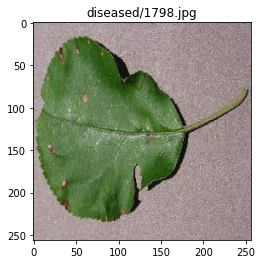

Prediction : ['diseased']


In [93]:
random_prediction()